# Line noise

wanted to try [Piralta 2002](https://doi.org/10.1006/jnca.2002.0142) NN (or maybe just SVM) of difference images, but there is too much noise!

This notebook turned into experiments with noise.

There is likely a frequence filter/fft solution. Maybe image deconvolution?

In [1]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq, fft

# load our code
sys.path.insert(0, os.path.abspath('../'))
from plotting import auto_draw
# specific to jupyter notebook
from jupyter_help import cvplt, cvplt_sub
#Import image processing function from optimization
# load any changes as we make them
%load_ext autoreload
%autoreload 2

vid_fname = "../input/run1.mov"
vs = cv2.VideoCapture(vid_fname)


## Image differences
from one frame to the next the average and the difference are very noisy

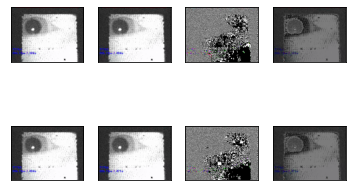

In [2]:
def get_frame(i):
    "frame at pos"
    vs.set(1, i)
    return vs.read()[1]
def avg_frame(f1,f2):
    return np.array((f1+f2)/2, dtype=int)

frames = [get_frame(i) for i in range(200,210)]

# mean each frame
cvplt_sub([frames[0], frames[1], (frames[0]-frames[1]), avg_frame(frames[0], frames[1]),
           frames[1], frames[2], (frames[1]-frames[2]), avg_frame(frames[1],frames[2])],2 ,4)

looking at every other doesn't help. the period of the scrolling lines is not a scale of 60Hz


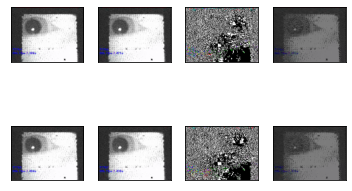

In [4]:
# every other
cvplt_sub([frames[0], frames[2], frames[0]-frames[2],avg_frame(frames[0],frames[2]),
          frames[1], frames[3], frames[1]-frames[3],avg_frame(frames[1],frames[3])],2 ,4)

The average of sequential frames does an interesting thing around the pupil.
is the difference of averages interesting?


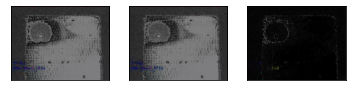

In [9]:
avg1 = avg_frame(frames[0], frames[1])
avg2 = avg_frame(frames[1], frames[2])
cvplt_sub([avg1,avg2,abs(avg1-avg2)],1,3)

## What is the nosie?
diagonal lines that scroll through the video

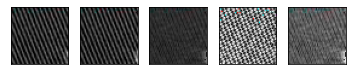

In [10]:
one=frames[0][2:50,2:50]
two=frames[1][2:50,2:50]
cvplt_sub([one, two, avg_frame(one,two), one-two, one+two],1,5)

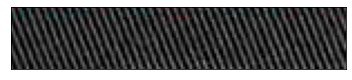

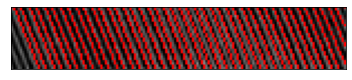

In [14]:
XMAX = 150 # lmit viewing to this width
Y = 0
frame_line = frames[0].copy()[2:30,0:XMAX]

# parameters to optimize
X0 = 1
M = 2.5 
W = 3.53


def find_end(x, m):
    x2 = XMAX    # end far off the screen
    y2 = int(Y-m*(x-x2))
    return (x2, y2)
def draw_line(frame):
    for x in np.arange(X0, XMAX, W):
        cv2.line(frame, (int(x),0), find_end(x, M), (255,0,0), 1)
    return(frame)

example = draw_line(frame_line.copy())
cvplt(frame_line)
cvplt(example)


In [15]:
mask = np.zeros((28,XMAX,3), np.uint8)
mask = draw_line(mask)
i = np.where(mask>0)
# TODO: mask image. take diff of masked image

## remove rgb color (reduce to 2D)



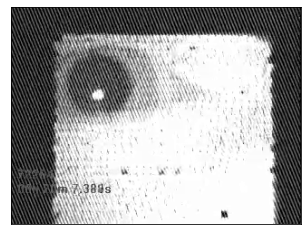

In [17]:
# meaning the colors does a good job keeping gray...gray
x=np.mean(frames[0],axis=2)
plt.gray()
cvplt(x)

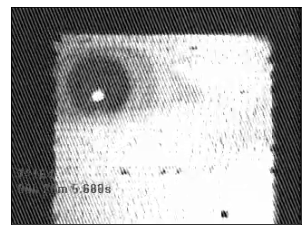

(240, 320)

In [18]:
def get_frame_sm_gray(i):
    "frame at pos"
    vs.set(1, i)
    frm = vs.read()[1]
    # sm = frm[2:30, 0:frm.shape[1]]
    sm = frm
    gry = np.mean(sm, axis=2)
    return gry

example = get_frame_sm_gray(100)
cvplt(example)
example.shape

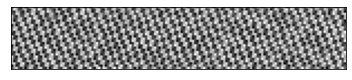

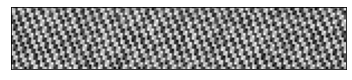

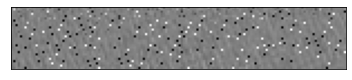

In [19]:
diff1 = np.mean(frames[0][2:30,0:XMAX] - frames[1][2:30,0:XMAX], axis=2)
diff2 = np.mean(frames[1][2:30,0:XMAX] - frames[2][2:30,0:XMAX], axis=2)
cvplt(diff1)
cvplt(diff2)
cvplt(avg_frame(diff1,diff2))

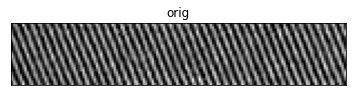

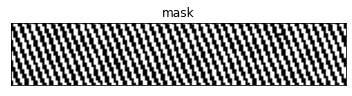

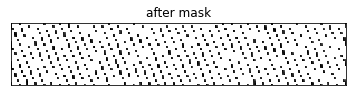

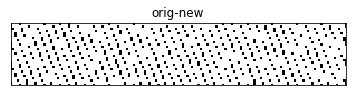

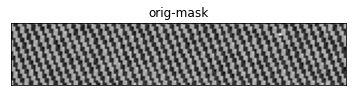

127

In [20]:
frame0 = np.mean(frames[0][2:30,0:XMAX], axis=2)
frame1 = np.mean(frames[1][2:30,0:XMAX], axis=2)
apply_to = frame1
thres =  255//2 #np.median(diff1)
mask = np.ma.masked_where(diff1 > thres, apply_to, copy=True)
new_frame = np.ma.masked_array(data=mask.data,mask=mask.mask, fill_value=0)
plt.title('orig'); cvplt(apply_to);
plt.title('mask'); cvplt(mask.mask);
plt.title('after mask'); cvplt(new_frame); 
plt.title('orig-new'); cvplt(apply_to - new_frame); 
plt.title('orig-mask'); cvplt(apply_to - 250*mask.mask); 

thres

## Collect across Time

We've concated the first 300 images. Lets look at what should be totally black points over time.

In [21]:
img_time = np.stack([get_frame_sm_gray(i) for i in range(0,300)],axis=2)
img_time.shape

(240, 320, 300)

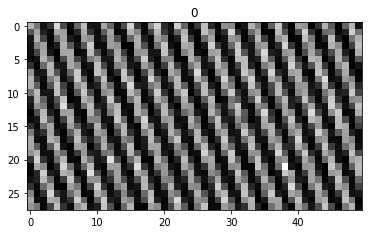

In [22]:
from matplotlib import animation, rc
rc('animation',html='html5')
f = plt.figure()
plt.title('init')
im = plt.imshow(img_time[2:30,0:50,0])
def upimg(i):
    plt.title(f'{i}')
    im.set_array(img_time[2:30,0:50,i])
    return im,
animation.FuncAnimation(f, upimg, frames=40, blit=False)

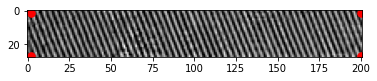

In [23]:
h=plt.imshow(img_time[2:30,0:201,20])
h=plt.plot( [2,200,2,200], [1,1,27,27], 'r.', markersize=15)

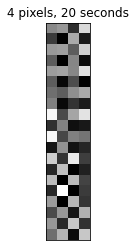

In [24]:
plt.title('4 pixels, 20 seconds')
cvplt(np.squeeze(img_time[[2,200,2,200], [1,1,27,27], :20]).T)


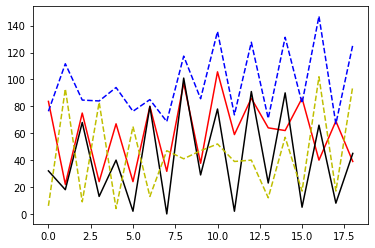

In [25]:
h = plt.plot(img_time[1,2,1:20], 'r-')    
h = plt.plot(img_time[1,200,1:20],'b--')  # horz=200
h = plt.plot(img_time[27,2,1:20], 'k-')
h = plt.plot(img_time[27,200,1:20],'y--') # horz=200

## Power spectrum

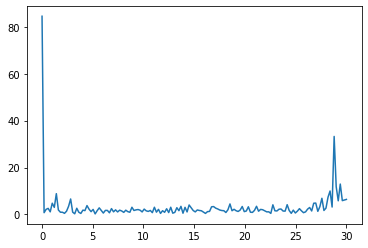

In [26]:
y = img_time[2,2,:]
N = len(y)
T = 60 # is this right? 60Hz, or should it be 1/60. x goes to 30 in the plot seems right
yf = fft(y)
xf = np.linspace(0.0, 1.0/2*T, N//2)
plt.plot(xf, 2.0/N * abs(yf[:N//2]))

Can we cut out anything greater than 25Hz? Will that kill saccades? Does it matter for our task?  Using 
 * https://stackoverflow.com/questions/39799821/how-to-remove-frequency-from-signal
 * https://stackoverflow.com/questions/31952560/python-bandpass-filter-of-an-image


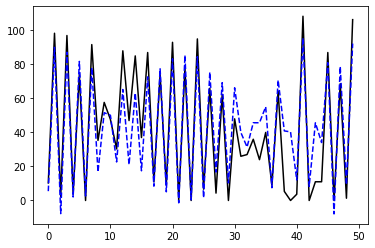

In [27]:
f_signal = rfft(y)
x = np.linspace(0.0, (N-1)*(1/T), N) # HERE: was T chagned to 1/T
W = fftfreq(y.size, d=x[1]-x[0])
cut_f_signal = f_signal.copy()
cut_f_signal[(W>1/25)] = 0  # filter all frequencies above 0.6
cut_signal = irfft(cut_f_signal)
h=plt.plot(y[:50],'k-')
h=plt.plot(cut_signal[:50],'b--')

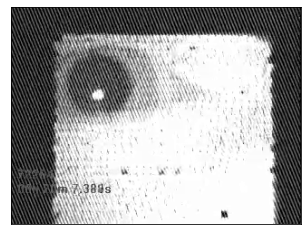

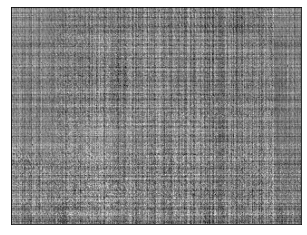

(240, 320)

In [179]:
img = get_frame_sm_gray(200)
f = np.fft.fft2(img)
fshift1 = np.fft.fftshift(f)          #shift the zero to the center
f_ishift = np.fft.ifftshift(fshift1)  #inverse shift
img_back = np.fft.ifft2(f_ishift)     #inverse fourier transform
img_back = np.abs(img_back)

(a, b) = fshift1.shape

ro = 8
ri = 5
y,x = np.ogrid[-a/2:a/2, -b/2:b/2] 
m1 = x*x + y*y >= ro*ro
m2 = x*x + y*y <= ri*ri
m3 = np.dstack((m1,m2))       
maskcomb =[]
#probably not pythonic, sorry
for r in m3:
    maskcomb.append([any(c) for c in r]) 
newma = np.invert(maskcomb)
filtdat = np.ma.array(fshift1,mask=newma) 
f_ishift = np.fft.ifftshift(filtdat) 
img_back2 = np.fft.ifft2(f_ishift) 
img_back2 = np.abs(img_back2)

cvplt(img_back2)
cvplt(img-img_back2)


## FFT again

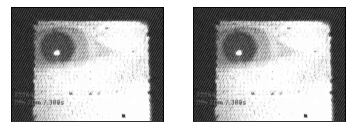

In [286]:
from numpy.fft import fft2, fftshift, ifft2, ifftshift
# confirm we can reconsturct
pat1 = np.mean(frames[0],axis=2)
spec_orig =fft2(pat1);
spec_img = fftshift(spec_orig);
ptnfx =  ifft2(ifftshift(spec_img))
cvplt_sub([pat1, ptnfx.real], 1, 2)

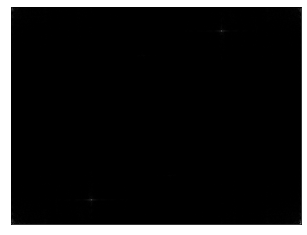

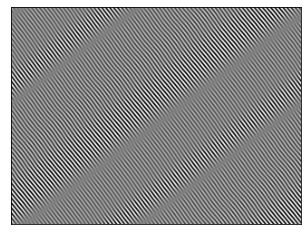

In [312]:
cvplt(abs(spec_orig.imag))
peak=[93,248]
s=10
#spec_img = fftshift(spec_orig);
# badspec=[120, 160]
#X = spec_img.copy()
#X[(badspec[0]-s):(badspec[0]+s),(badspec[0]-s):(badspec[0]+s)] = 0
X = np.zeros(spec_img.shape,dtype='complex')
ix = peak[0] + np.arange(s)-2*s
iy = peak[1] + np.arange(s)-2*s
X[ix,iy] = spec_img[ix,iy]
ptnfx =  ifft2(ifftshift(X))
cvplt(ptnfx.real)

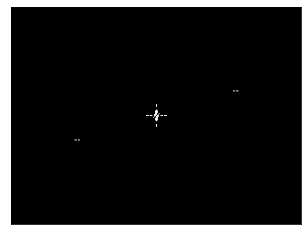

In [177]:
pat1 = np.mean(frames[0],axis=2)

spec_orig = np.fft.fft2(pat1); 
spec_img = np.fft.fftshift(spec_orig);
# widget
%matplotlib inline   
cplx = abs(np.imag(spec_img))
thres = np.max(cplx)/10
cplx_mask=np.ma.masked_greater(abs(cplx), thres, copy=T)
cvplt(cplx_mask.mask)
coords = np.argwhere(cplx>thres)


## center of spectrum peaks with Kmeans

shape (240, 320), idxes [[120 160]
 [ 93 248]
 [147  72]]


array([     0.        , 958190.29717272, 958190.29717272])

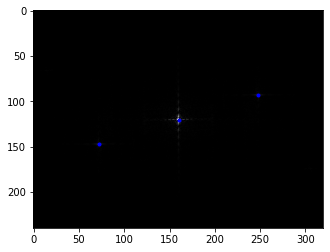

In [178]:
import sklearn.cluster as clust
pts = clust.KMeans(n_clusters=3).fit(coords)
# this is weird. imshow puts 0 on top. adjust coords
plt_centers = pts.cluster_centers_.T[[1,0]]
plt.imshow(cplx)
plt.plot(plt_centers[0],plt_centers[1], 'b.')

idx = np.array(np.round(pts.cluster_centers_),dtype=int)
print(f'shape {cplx.shape}, idxes {idx}')
# one of these is the center. we don't want to mask that one out
cplx[idx[:,0],idx[:,1]]

clearing [120 160]
clearing [ 93 248]
clearing [147  72]


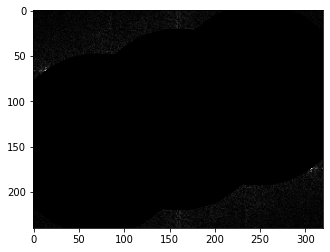

In [302]:
# https://stackoverflow.com/questions/53326570/how-to-create-a-sphere-inside-an-ndarray
def create_bin_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2) 
    return distance <= r

# remove spheres of data
X = spec_img.copy()
# stupid way to exclude middle point [120 160]
#clear_idx = [i for i in idx if not (i[0] > 110 and i[0] < 170 and i[1] > 110 and i[1] < 170)]
for i in idx:
    print(f'clearing {i}')
    mask = create_bin_sphere(spec_img.shape, i, 100)
    X[mask] = 0
plt.imshow(abs(X.imag))
#pltpnts=np.array(clear_idx).T[[1,0]]
#plt.plot(pltpnts[0],pltpnts[1], 'b.')


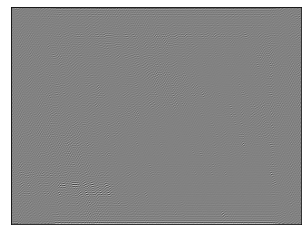

In [303]:
ptnfx = ifft2(ifftshift(X))
cvplt(ptnfx.real);
